In [208]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import pytesseract
import re
#pytesseract.pytesseract.tesseract_cmd = "C:\Users\Lakshmi\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output

In [209]:
# from Fetch_images import storage
# all_files = storage.child().list_files()
# for file in all_files:            
#     try:
#         print(file.name) 
#         storage.download(file.name, file.name)
#     except:    
#         print('Download Failed')

C:\Users\SANDRA\AppData\Local\Temp\ipykernel_14660\1643256469.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


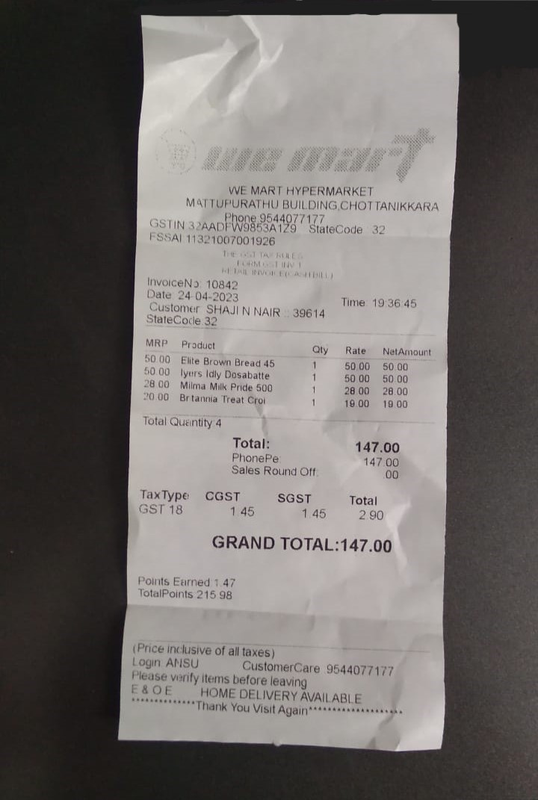

In [210]:
from Fetch_images import storage
storage.child()
storage.download("receipt.jpeg" ,"temp.jpg" )
file_name = "receipt.jpeg"
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [211]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')


In [212]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

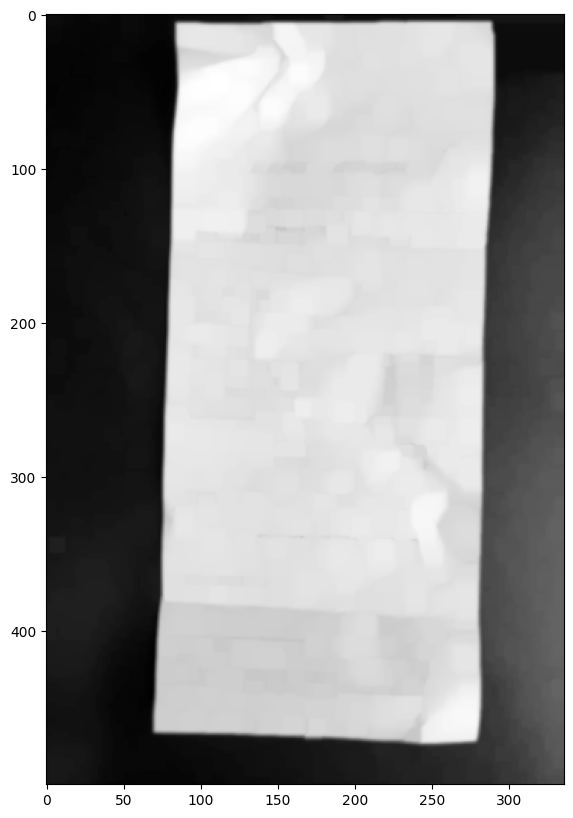

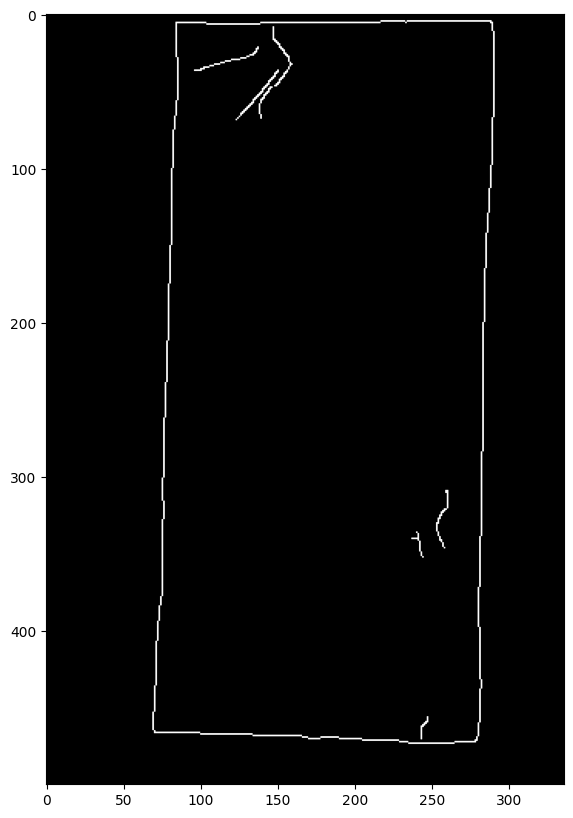

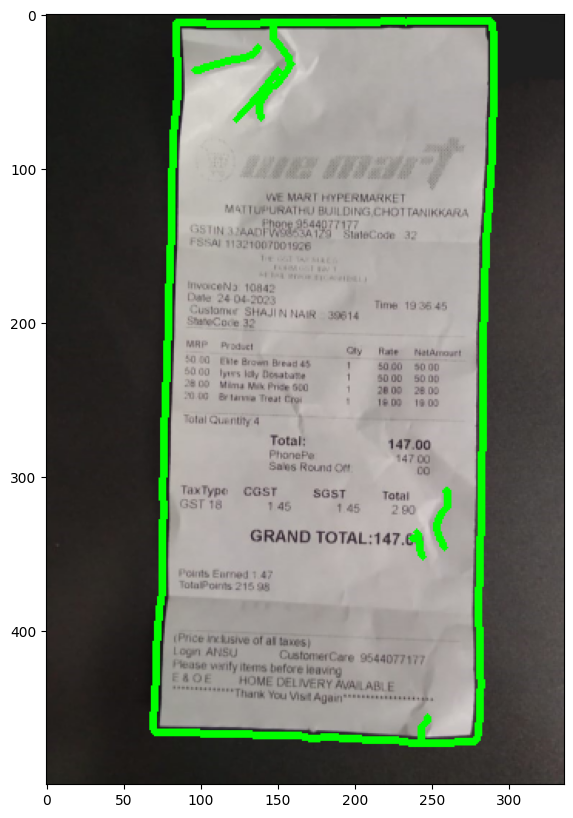

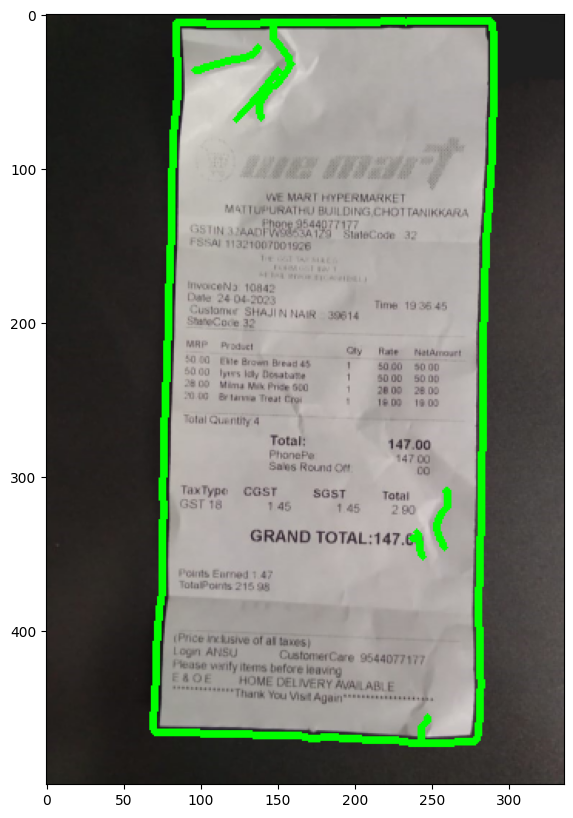

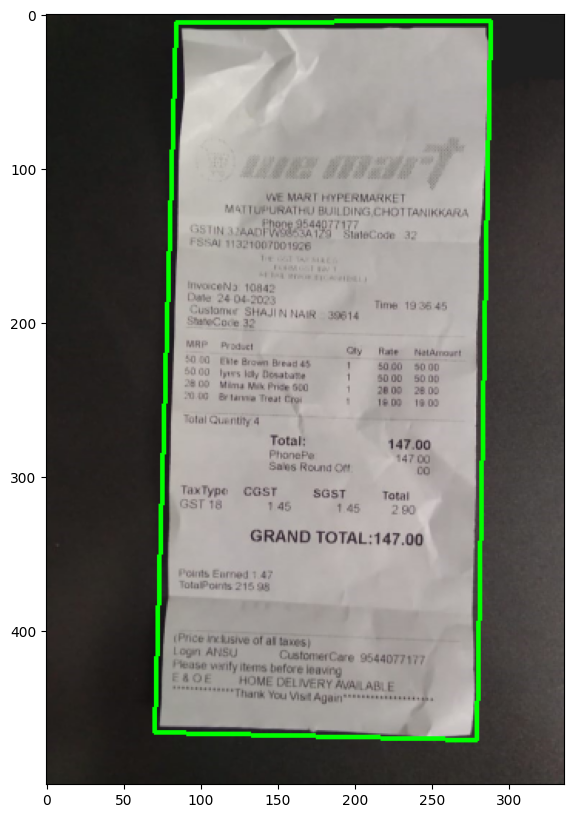

In [213]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#plot_gray(gray)

# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#plot_gray(blurred)

# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

edged = cv2.Canny(dilated, 50,100, apertureSize=3)
plot_gray(edged)

# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

#for images that have other objects detected
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

#
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [214]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))


#b&w scanner effect
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

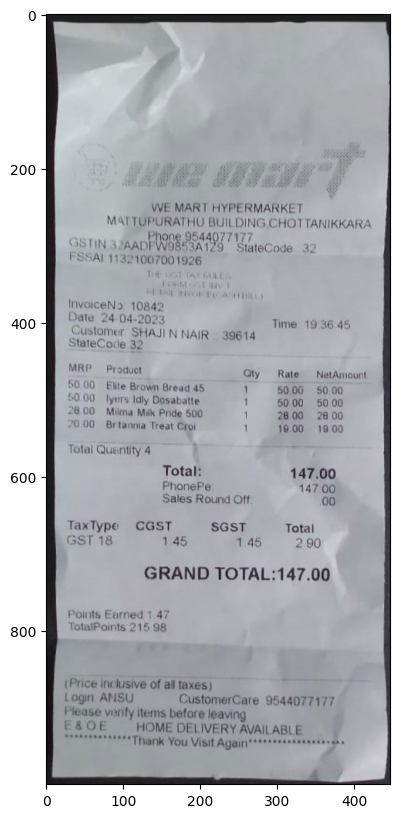

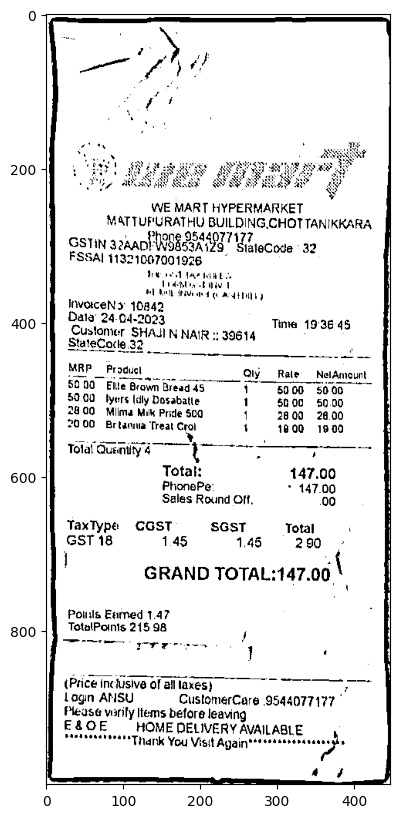

In [215]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

result = bw_scanner(scanned)
plot_gray(result)

WE MART HYPERMARKET
MATTUFURATHU BUILDING.CHOTTANIKKARA

GStiN 3zhan OBER eeecode 32
FSSAI 11321007001: 926
We wd tae oats

Moya div
Wve te ar HN p

Invorcen >: 10842
Data’ 24-04-2023 Timea 19°36-46

Customer SHAJ]N NAIR 3: 39614
StateCocle 32 R *

MRP Product j Netamnount
S000” Eile Brown Bread 45 5660
50.00 tyers (aly Dosabatte $0.00
2400 Milma Mik Pride $00 24.00
2000 Brtamua Treat Crot 1900
Tolal Guenilty4 7

Total: 147.00

PhonePa: + 147.00

Sales Round Off, 00

TaxType CGST SGST Total
GST 18 145 1,45 290

} GRAND TOTAL:147.00

Poitils Earned 1.47
TotalPoints 215 98

oe prey

(Price inclusive of ail taxes) a
Lagin ANSU CustomerCare 9544077177
Please vorily Items before leaving
HOME DELIVERY AVAILABLE
“Thank You Visit Again***s+4sssee4




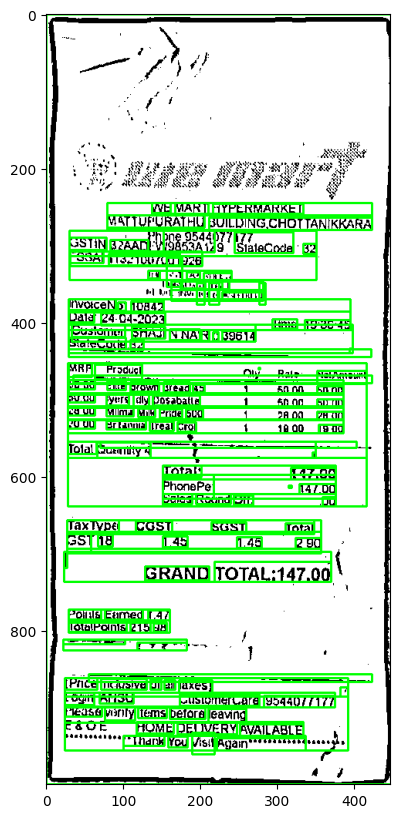

In [216]:
pytesseract.pytesseract.tesseract_cmd = r"C:/Users/SANDRA/AppData/Local/Programs/Tesseract-OCR/tesseract"

d = pytesseract.image_to_data(result, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(result.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

extracted_text = pytesseract.image_to_string(result)
print(extracted_text)

In [217]:
extracted_text=extracted_text.lower()
lst= extracted_text.split('\n')
lst1=['item','mrp','qty','product','rate']

count=0
ctr =0
flag=0
for i in lst:
    count+=1
    #print(i)
    # print(i.split())
    for j in lst1:
        # print(j)
        if j in i.split():
            flag=1
            break
    if flag==1:
        break




In [218]:
import pickle
from joblib import dump, load
with open('SVC_model.pkl', 'rb') as f:
    model = load(f)

In [219]:

lst2=['total','tolal','lolal','tatal','totol','lotol','yotal']
flag=0
lst3=lst[count:]
words_pattern = '[a-z]+'
# words_pattern = '^[a-z_]+$'
for i in lst3:
    for j in lst2:
        # print(j)
        if j in i.split():
            flag=1
            break
    if flag==1:
        break
    text=lst[count]
    # if(text.__contains__(words_pattern)):
    # print(text)
    #print()
    temp=re.findall(words_pattern, text, flags=re.IGNORECASE)
    text= " ".join(temp)
    txt = [text]
    prediction = model.predict(txt)
    # if(prediction!='Beauty & Hygiene'):
    print(txt)
    print(prediction)
    print()
    count+=1
    



['s eile brown bread']
['Bakery, Cakes & Dairy']

['tyers aly dosabatte']
['Beauty & Hygiene']

['milma mik pride']
['Beauty & Hygiene']

['brtamua treat crot']
['Foodgrains, Oil & Masala']



In [220]:
# def find_amounts(text):
#     amounts = re.findall(r'\d+\.\d{2}\b', text)
#     floats = [float(amount) for amount in amounts]
#     unique = list(dict.fromkeys(floats))
#     return unique

# amounts = find_amounts(extracted_text)
# amounts
# # max(amounts)